## Monte Carlo simulation of stable membrane curvatures

##### Using functions from mem_curve.py

In [1]:
# Standard imports
import matplotlib.pyplot as plt
import pandas as pd
import os
# For reading csv
import csv
import re
# For power spectrum
from scipy.signal import periodogram

# Custom imports
from mem_curve import *

### Running simulation, replica exchange, annealing

#### Simulation:
Initialise model membrane, run Monte Carlo for <n> steps

#### Replica exchange:
Access surfaces otherwise separated by potential barriers...
Tune kbT factor up & down to alter acceptance ratio from equilibrium ensemble
Run parallel simulation windows, can swap replicas between kbT environments

#### Annealing:
Slowly return kbT factor to equilibrium
If too quick, will form "glass" -- initially all moves "downhill" & become trapped in metastable state space

In [6]:
# Choose number of Monte Carlo steps
nsteps = 30000

# Choose directory to save
save_dir = 'distortedstart/trial1'
os.makedirs(f'./{save_dir}/', exist_ok=True)
# Initialise membrane ensemble
membrane_lst = [init_model_membrane()]

In [7]:
# OPTIONAL !
# Make distortion to initial membrane
membrane_lst[0]['alpha'] += 1
membrane_lst[0]['beta'] -= 1
membrane_lst[0]['gamma'] -= 1
membrane_lst[0]['zeta'] += 1

# Calculate first membrane energy
# Calculate shape operator
S = calc_shape_operator(membrane_lst[0], params.X, params.Y)
# Calculate mean and Gaussian curvatures
H   = calc_H(S)
K_G = calc_K_G(S)
# Calculate bending energy
bending_energy = calc_Helfrich_energy(H, K_G)

# Add energy to dictionary attributes
membrane_lst[0]['energy'] = bending_energy

print(bending_energy)

844.796060755596


In [8]:
# Track acceptance probability
naccepts      = 0
accepts_track = []

# Run simulation
for step in range(1,nsteps+1):
    
    membrane_lst, accept_move = montecarlostep(membrane_lst)
    
    naccepts += 1 if accept_move else 0
    accepts_track += [naccepts]
    
    if step%2000==0 and step!=0:
        print(f'Step {step}: accepted moves {naccepts}')

print('Acceptance ratio:', naccepts/nsteps)

Step 2000: accepted moves 1549
Step 4000: accepted moves 3223
Step 6000: accepted moves 4983
Step 8000: accepted moves 6783
Step 10000: accepted moves 8609
Step 12000: accepted moves 10460
Step 14000: accepted moves 12337
Step 16000: accepted moves 14201
Step 18000: accepted moves 16077
Step 20000: accepted moves 17947
Step 22000: accepted moves 19835
Step 24000: accepted moves 21701
Step 26000: accepted moves 23603
Step 28000: accepted moves 25474
Step 30000: accepted moves 27340
Acceptance ratio: 0.9113333333333333


In [9]:
# Save data to a csv

df = pd.DataFrame(membrane_lst)

df.to_csv(f'./{save_dir}/model_membranes.csv', index=False)

### load data from saved csv

In [3]:
def string_to_array(s):
    s_clean = re.sub(r'[\[\]]', '', s)
    if ' ' not in s_clean:
        return float(s_clean)
    return np.array([[float(x) for x in line.split() if x]
                     for line in s_clean.strip().split('\n')])

with open(f'./{save_dir}/model_membranes.csv', mode='r', newline='') as file:
    reader = csv.DictReader(file)
    membrane_lst = []
    for row in reader:
        parsed_row = {}
        for key, val in row.items():
            parsed_row[key] = string_to_array(val)
        membrane_lst.append(parsed_row)

### Data Analysis

#### Equilibration

How does ratio of accepted moves evolve?

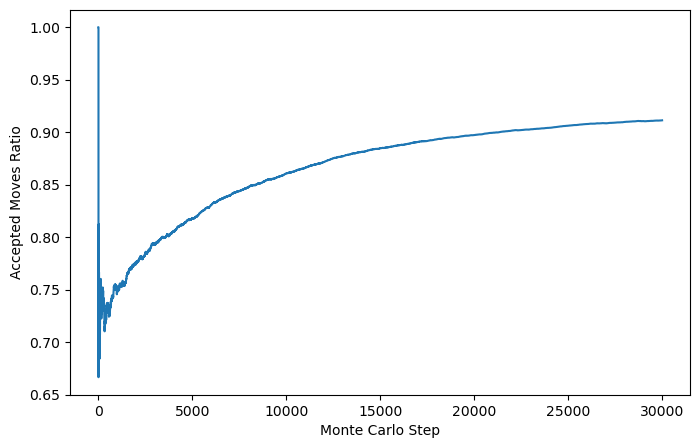

In [10]:
mcsteps_arr = np.linspace(1,nsteps,nsteps)
ratio_arr = np.array(accepts_track)/mcsteps_arr

plt.figure(figsize=[8,5])
plt.ylabel('Accepted Moves Ratio')
plt.xlabel('Monte Carlo Step')
plt.plot(mcsteps_arr, ratio_arr)
plt.savefig(f'./{save_dir}/naccepts.pdf')
plt.show()

#### Plot bending energy vs Monte Carlo step
#### Plot mean curvature vs Monte Carlo step
#### Plot Gaussian curvature vs Monte Carlo step
^ are these values expected? Are states stable &/ in equilibrium ensemble?

In [11]:
# Extract bending energy from membrane_lst of dictionaries
energy_lst = [ membrane['energy'] for membrane in membrane_lst ]

# Calculate values every <nframes>
nframes = 10

H_lst = []
K_lst = []

for membrane in membrane_lst[::nframes]:

    # Calculate shape operator
    S = calc_shape_operator(membrane, params.X, params.Y)
    # Calculate mean and Gaussian curvatures
    H_lst += [np.sum(calc_H(S))]
    K_lst += [np.sum(calc_K_G(S))] 

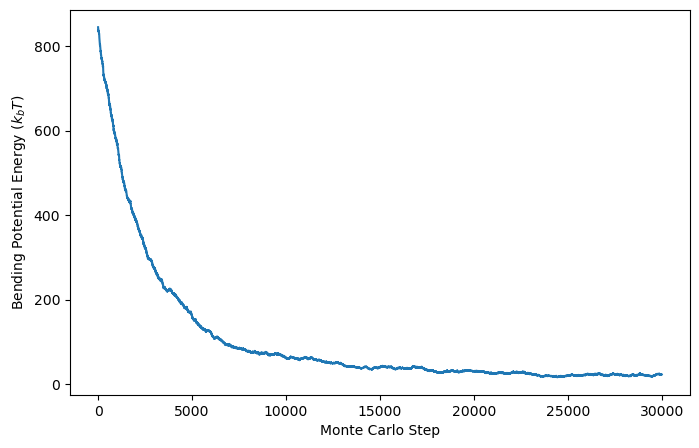

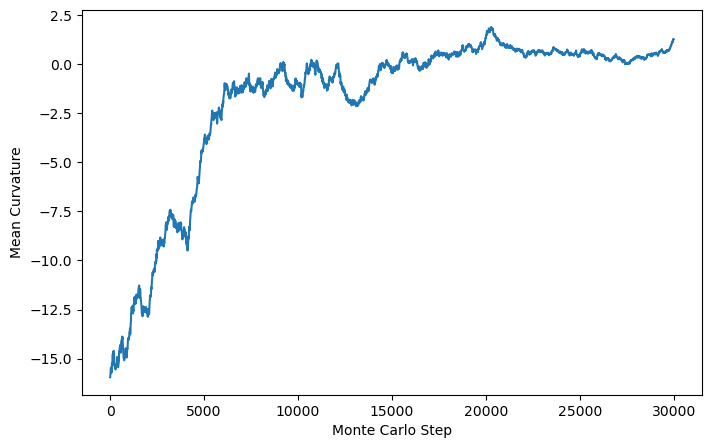

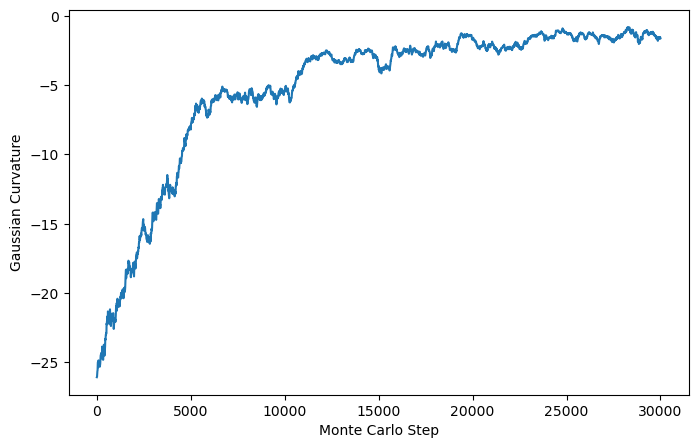

In [12]:
# Plot energy
plt.figure(figsize=[8,5])
plt.ylabel('Bending Potential Energy ($k_bT$)')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1), energy_lst)
plt.savefig(f'./{save_dir}/bending_energy.pdf')
plt.show()

# Plot mean curvature
plt.figure(figsize=[8,5])
plt.ylabel('Mean Curvature')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), H_lst)
plt.savefig(f'./{save_dir}/mean_curvature.pdf')
plt.show()

# Plot Gaussian curvature
plt.figure(figsize=[8,5])
plt.ylabel('Gaussian Curvature')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), K_lst)
plt.savefig(f'./{save_dir}/Gaussian_curvature.pdf')
plt.show()

#### Take mean of height 
From equilibrium sampled region

Is average membrane structure flat?

#### Take mean squared height
How does membrane thickness compare to CWT..?

$\langle h(\textbf{r})^{2} \rangle = \frac{k_bT}{16\pi^{3} \kappa} L^{2} $

In [16]:
# Skip steps before equilibrium
nskip = 5000

# Calculate values every <nframes>
nframes = 10

# Simulated values
mean_height   = 0 
meansq_height = 0 

for membrane in membrane_lst[nskip::nframes]:

    # Calculate height
    mem_height     = calc_height(membrane, params.X, params.Y)
    mean_height   += np.mean(mem_height) # average over all grids
    meansq_height += np.max(mem_height)**2 /2 + np.min(mem_height)**2 /2
    
mean_height   /= len(membrane_lst[nskip::nframes])
meansq_height /= len(membrane_lst[nskip::nframes])

# Theoretical value (from Capillary Wave Theory on membranes)
cwt_meansq_h = params.kbT / (16 * np.pi**3 * params.kappa_H) * params.l_x * params.l_y

In [17]:
print(f'''
<h> = {mean_height} (simulated)
<h> = 0.0 (CWT)

<h^2> = {meansq_height} (simulated) 
<h^2> = {cwt_meansq_h} (CWT)''')


<h> = 1.4655351278785633 (simulated)
<h> = 0.0 (CWT)

<h^2> = 9.556144476996375 (simulated) 
<h^2> = 0.25196511275937106 (CWT)


#### Visualising membrane curvature

In [20]:
# Set plots as pop-ups
%matplotlib qt

In [ ]:
# Visualise membrane curvatures with contour plot movie
visualise(membrane_lst, nframes=100, save_dir=save_dir)

In [ ]:
# Set plots to in line
%matplotlib inline

#### Save logging info

In [18]:
log_str = f'''
# # # Parameters # # #

Box parameters:
l_x       = {params.l_x}       # Box size, x-direction
l_y       = {params.l_y}       # Box size, y-direction
exp_order = {params.exp_order}        # Order of 2D Fourier expansion
npts      = {params.npts_x}, {params.npts_y} # Number of points in each X, Y for grid calculations

Bending energies:
H_0     = {params.H_0}        # Optimum mean curvature
kappa_H = {params.kappa_H}        # Bending modulus of mean curvature (kbT units)
kappa_K = {params.kappa_K}        # Bending modulus of Gaussian curvature (kbT units)

Size of Monte Carlo moves:
delta = {params.delta}        # Standard deviation of perturbation applied to Fourier coefficients

Number of steps:
nsteps = {nsteps}


# # # Results # # #

Acceptance ratio   = {naccepts/nsteps}

Curvature:
Bending energy     = {np.mean(energy_lst[int(nskip/nframes):])}
Mean curvature     = {np.mean(H_lst[int(nskip/nframes):])}
Guassian curvature = {np.mean(K_lst[int(nskip/nframes):])}

Membrane height:
mean height = {mean_height} (simulated)
mean height = 0.0                   (CWT)
mean squared height = {meansq_height} (simulated)
mean squared height = {cwt_meansq_h} (CWT)

Note: averages after {nskip} steps
'''

filename = f"./{save_dir}/log.txt"

# Write the string to the file
with open(filename, "w") as file:
    file.write(log_str)

#### Histogram of curvatures

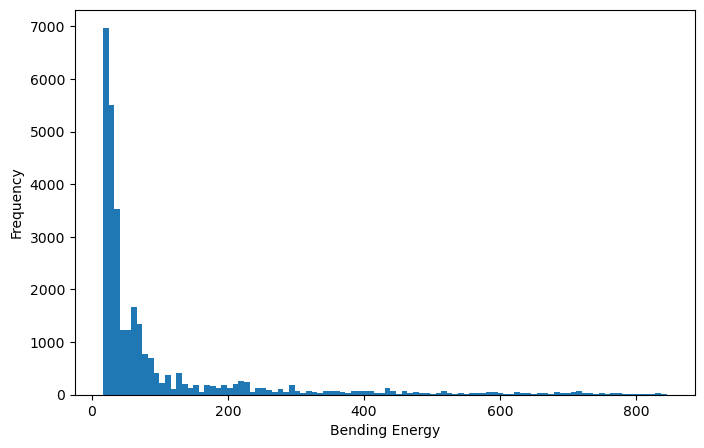

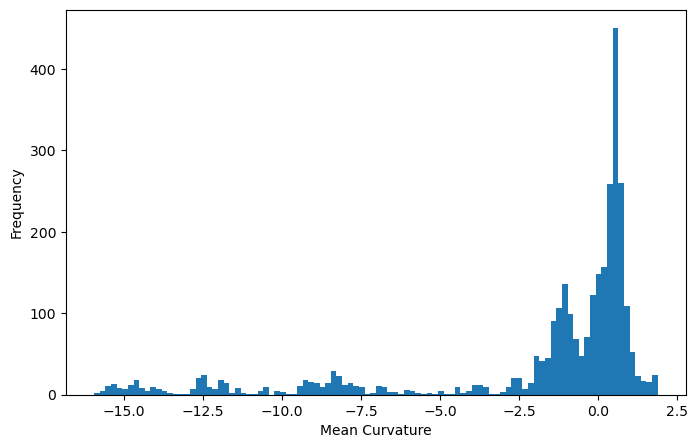

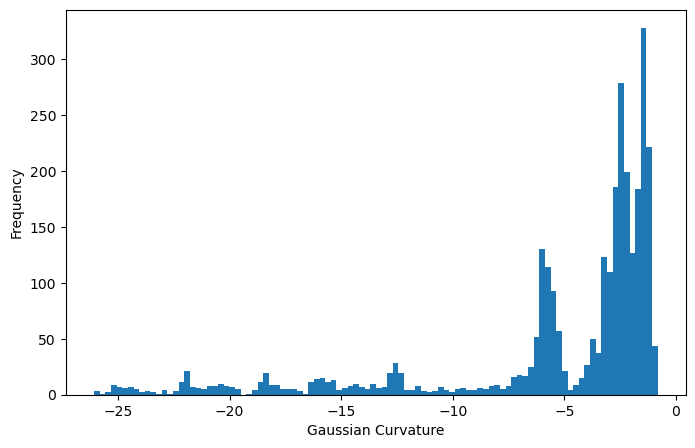

In [19]:
plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Bending Energy')
plt.hist(energy_lst, bins=100)
plt.savefig(f'./{save_dir}/Gaussian_curvature_bin.pdf')
plt.show()

plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Mean Curvature')
plt.hist(H_lst, bins=100)
plt.savefig(f'./{save_dir}/Gaussian_curvature_bin.pdf')
plt.show()

plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Gaussian Curvature')
plt.hist(K_lst, bins=100)
plt.savefig(f'./{save_dir}/Gaussian_curvature_bin.pdf')
plt.show()

#### Plot Fourier Coefficients

$
h(x, y) =
\sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \alpha_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \beta_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \gamma_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \delta_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
$


In [ ]:
nskip = 5000

# Calculate mean Fourier coefficients
alpha_lst, beta_lst, gamma_lst, zeta_lst = [], [], [], []

for membrane in membrane_lst[:nskip]:
    alpha_lst += [membrane['alpha']]
    beta_lst  += [membrane['beta']]
    gamma_lst += [membrane['gamma']]
    zeta_lst  += [membrane['zeta']]

alpha_mean = np.mean(alpha_lst, axis=0)
beta_mean  = np.mean(beta_lst, axis=0)
gamma_mean = np.mean(gamma_lst, axis=0)
zeta_mean  = np.mean(zeta_lst, axis=0)

Fcoeff_means = [alpha_mean, beta_mean, gamma_mean, zeta_mean]

In [ ]:
# Plot mean Fourier coeff values
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

titles = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\zeta$']

# find maximum absolute value for colourbar reference
maxval = np.max(Fcoeff_means) if np.max(Fcoeff_means)>abs(np.min(Fcoeff_means)) else np.min(Fcoeff_means)

for idx, (ax, cm) in enumerate(zip(axes, Fcoeff_means)):
    im = ax.imshow(cm, cmap='coolwarm', vmin=-abs(maxval), vmax=abs(maxval))
    ax.set_title(titles[idx], fontsize=15)

    # Annotate each cell
    for i in range(params.exp_order):
        for j in range(params.exp_order):
            ax.text(j, i, f'{round(Fcoeff_means[idx][i,j],2)}',
                    ha='center', va='center',
                    color='white' if cm[i, j] > cm.max() / 2 else 'black',
                    fontsize=12, fontweight='bold')

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    if idx in [2,3]:
        ax.set_xlabel(r'Column Index, $m$', fontsize=12)
    if idx in [0,2]:
        ax.set_ylabel(r'Row Index, $n$', fontsize=12)

# Add a shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.04, pad=0.04)
#cbar.set_label('Mean Fourier Coefficient Value', fontsize=13)

#plt.tight_layout(pad=2)
plt.savefig(f'./{save_dir}/Fcoeff.pdf')
plt.show()

In [ ]:
# Visualise 'mean surface'
# X,Y grid
npts = 100
x = np.linspace(-params.l_x/2, params.l_x/2, npts)
y = np.linspace(-params.l_y/2, params.l_y/2, npts)
X, Y = np.meshgrid(x, y)

# Calculate z-direction (heights)
mean_membrane = {
    'alpha' : alpha_mean,
    'beta'  : beta_mean,
    'gamma' : gamma_mean,
    'zeta'  : zeta_mean} 

Z = calc_height(mean_membrane, X, Y)

# Animation plot
fig, ax = plt.subplots(figsize=[8, 6])

# Initial contour and colorbar
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis', vmin=np.min(Z), vmax=np.max(Z))
cbar = fig.colorbar(contour, ax=ax)

# Labels
cbar.set_label("Height")
#title = ax.set_title("Mean Membrane Height")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.savefig(f'./{save_dir}/mean_surface.pdf')
plt.show()

#### Power Spectrum

In [ ]:
# Calculate power spectrum
f, Pxx = periodogram(energy_lst)

In [ ]:
upto = 500
plt.figure(figsize=[8,5])
plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency')
plt.plot(f[:upto], Pxx[:upto])
plt.savefig(f'./{save_dir}/pwr_spectral_dens.pdf')
plt.show()